In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import xgboost as xgb
df = pd.read_csv("pr2.tsv", sep="\t")
le = LabelEncoder()
le.fit(df["draft_quality"].unique())
df["draft_quality"] = le.transform(df["draft_quality"])
df = shuffle(df)
Y=np.array(df["draft_quality"])
X=df.drop(["draft_quality"], 1)

X["feature.wikitext.revision.entity_chars"] = X["feature.wikitext.revision.entity_chars"].apply(lambda x: int(x))
X['entier'] = X["feature.(english.stemmed.revision.stems_length / max(wikitext.revision.content_chars, 1))"].apply(lambda x: int(x))
clf = xgb.XGBClassifier(max_depth=7, objective='multi:softmax' , learning_rate=0.2)


In [2]:
indexes=X.index.values
%matplotlib inline
# hold out 20 percent of data for testing accuracy
X=np.array(X)
Y=np.array(Y)
validation_prct = 0.8
n_validation = int(round(X.shape[0]*validation_prct))
X_prevalid=X[:n_validation]
Y_prevalid=Y[:n_validation]
X_valid=X[n_validation:]
Y_valid=Y[n_validation:]

#### Training The xgboost using cross-validation method

In [73]:
i=1
means=[]
from sklearn.cross_validation import KFold
kf = KFold(len(Y_prevalid), n_folds=5, shuffle=True)
for training,testing in kf:
    print("iteration "+str(i))
    clf.fit(X_prevalid[training], Y_prevalid[training])
    prediction = clf.predict(X_prevalid[testing]) 
    curmean = np.mean(prediction == Y_prevalid[testing])
    means.append(curmean)
    i+=1
    print(curmean)
print("Mean accuracy: ".format(np.mean(means)))

iteration 1
0.852552659764
iteration 2
0.846959419255
iteration 3
0.850291562537
iteration 4
0.849101511365
iteration 5
0.849678647941
Mean accuracy: 


#### plotting the prediction

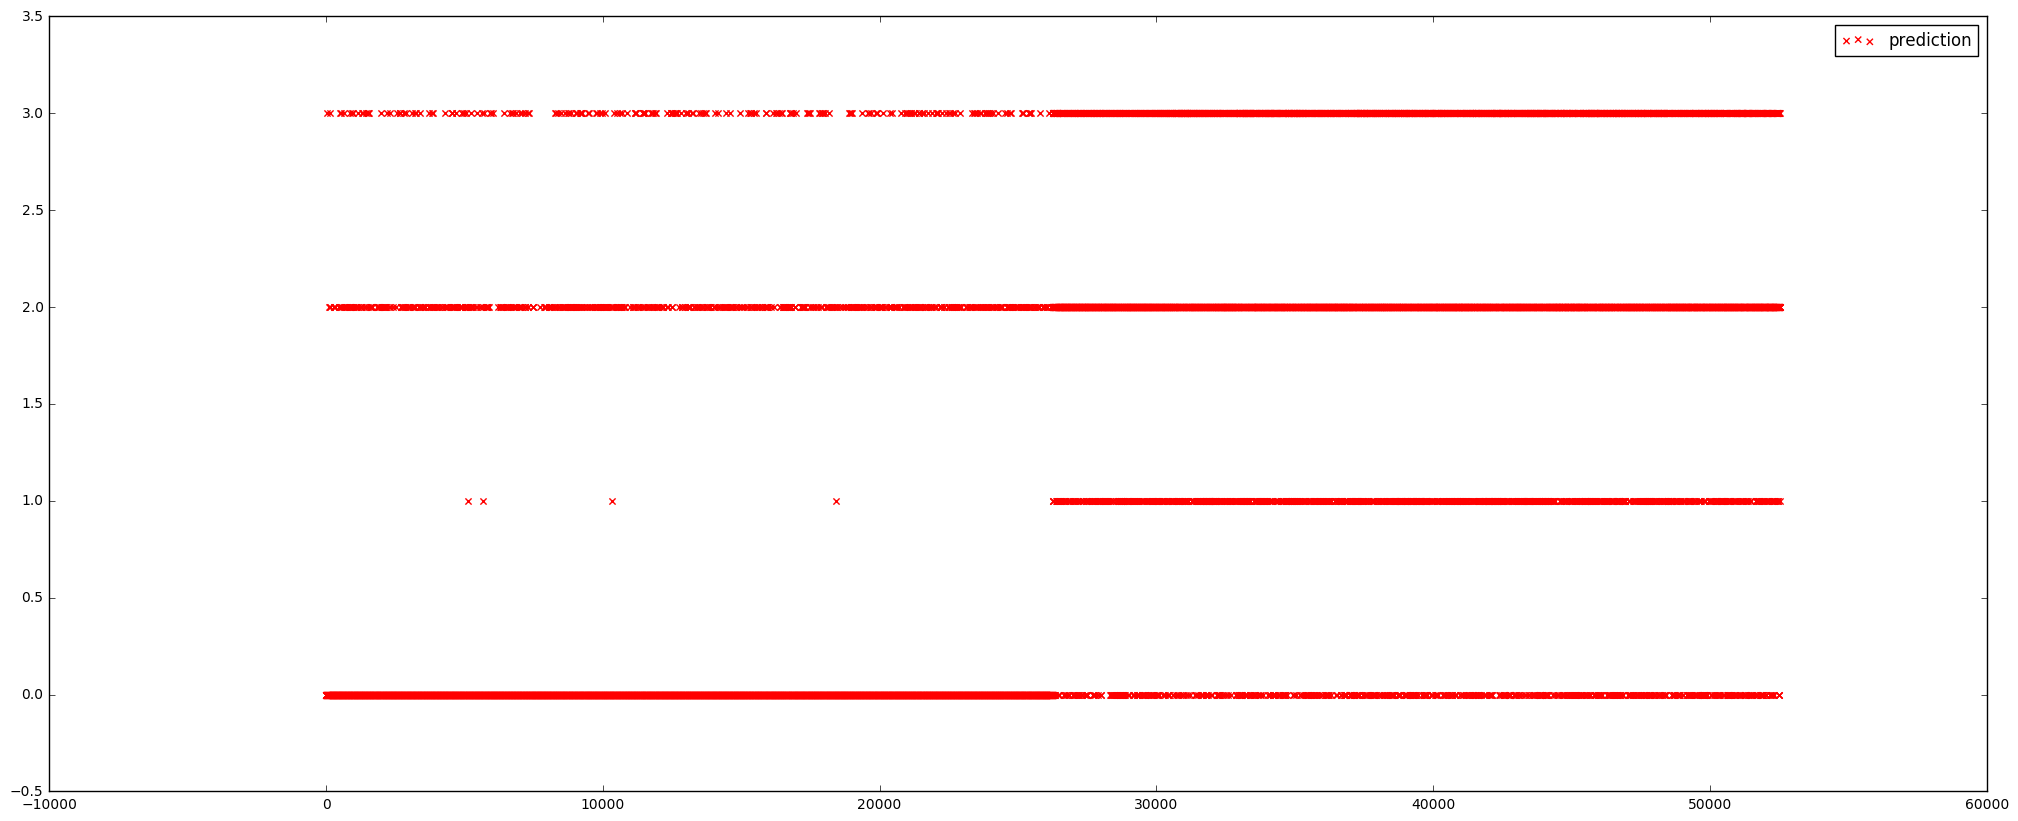

In [74]:
prediction_all = clf.predict(X)
plt.figure(figsize=(25,10))
plt.scatter(indexes, prediction_all, color='r', label='prediction', marker="x")
plt.legend()


#### plotting the real labels

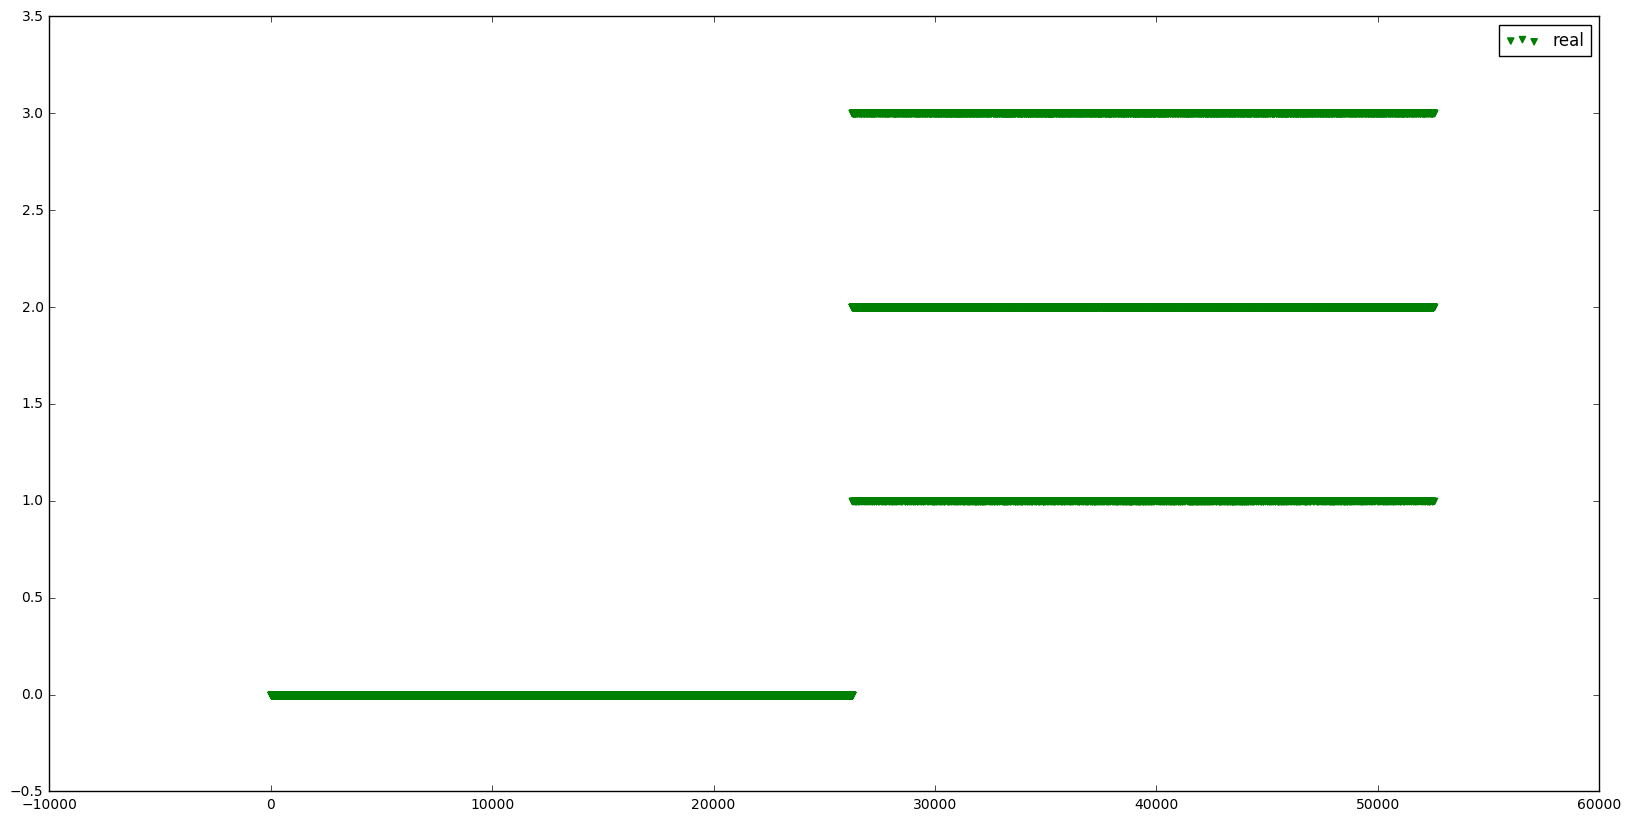

In [75]:
plt.figure(figsize=(20,10))
plt.scatter(indexes, Y, color='g', label='real', marker="v")
plt.legend()

#### Now try on validation dataset

In [76]:
clf.fit(X_prevalid, Y_prevalid)
prediction = clf.predict(X_valid) 
curmean = np.mean(prediction == Y_valid)
print(curmean)

0.85662604722


#### confusing matrix

In [77]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_valid, prediction))

[[5044    4  210   70]
 [  12   56   85  244]
 [ 121   10 3141  219]
 [ 131   57  343  757]]


#### trying an oversampling method

In [78]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_prevalid, Y_prevalid = ros.fit_sample(X_prevalid, Y_prevalid)

In [79]:
i=1
means=[]
from sklearn.cross_validation import KFold
kf = KFold(len(Y_prevalid), n_folds=5, shuffle=True)
for training,testing in kf:
    print("iteration "+str(i))
    clf.fit(X_prevalid[training], Y_prevalid[training])
    prediction = clf.predict(X_prevalid[testing]) 
    curmean = np.mean(prediction == Y_prevalid[testing])
    means.append(curmean)
    i+=1
    print(curmean)
print("Mean accuracy: ".format(np.mean(means)))

iteration 1
0.903428093645
iteration 2
0.908140715523
iteration 3
0.903840410918
iteration 4
0.903183419937
iteration 5
0.90849907424
Mean accuracy: 


In [80]:
clf.fit(X_prevalid, Y_prevalid)
prediction = clf.predict(X_valid) 
curmean = np.mean(prediction == Y_valid)
print(curmean)

0.835681645088


In [81]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_valid, prediction))

[[4988   35  185  120]
 [   8  165   50  174]
 [  99   97 2936  359]
 [ 106  273  220  689]]


#### Voting : combining mutiple classifiers

In [5]:
from sklearn.ensemble import RandomForestClassifier
clf1=RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini')

In [6]:
from sklearn.neighbors import KNeighborsClassifier
clf2 = KNeighborsClassifier(n_neighbors=14)

In [9]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[('xgb', clf), ('rf', clf1), ('knn', clf2)], voting='soft', weights=[2,1,1])
eclf1 = eclf1.fit(X_prevalid, Y_prevalid)
prediction=eclf1.predict(X_valid)
curmean = np.mean(prediction == Y_valid)
print(curmean)

0.797410510282
